c:\ProgramData\anaconda3\envs\sigpy2\lib\site-packages\sigpy\config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(
c:\ProgramData\anaconda3\envs\sigpy2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


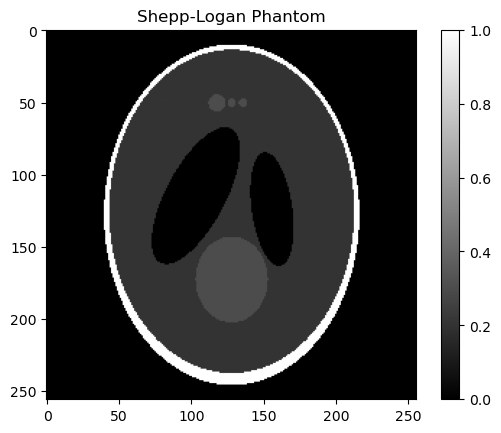

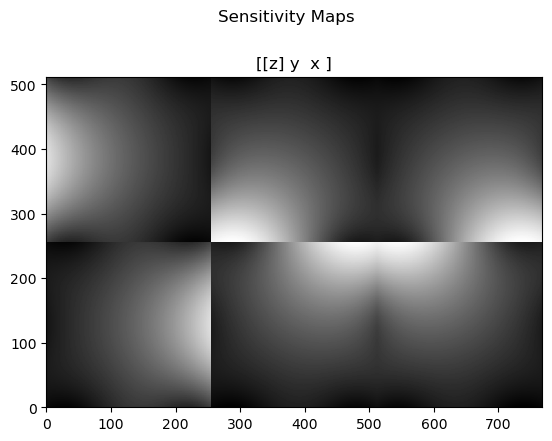

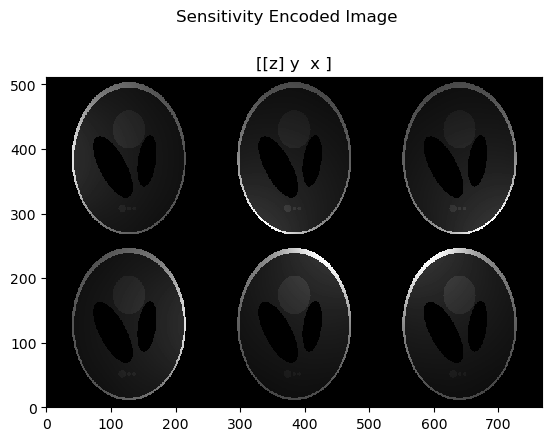

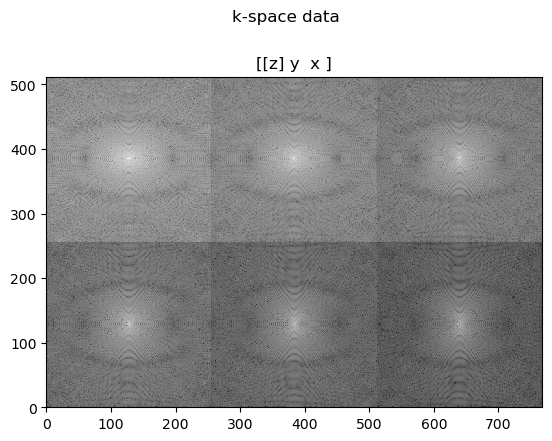

(6, 256, 256)


In [1]:
import numpy as np
import sigpy as sp
import sigpy.mri as mri
import matplotlib.pyplot as plt
import sigpy.plot as pl


# 画像サイズ（256x256）
img_size = 256
img_shape = (img_size, img_size)
# Shepp-Logan Phantom の生成
phantom = sp.shepp_logan(img_shape)

# 表示
plt.imshow(np.abs(phantom), cmap='gray')
plt.title("Shepp-Logan Phantom")
plt.colorbar()
plt.show()


num_coils = 6
mps = mri.birdcage_maps((num_coils, *img_shape))  # (6, 128, 128)
if num_coils == 1:
    mps = np.ones((1, *img_shape), dtype=complex)

pl.ImagePlot(mps, title='Sensitivity Maps', z=0)

img_sense = phantom * mps  # コイルごとの感度を適用
ksp = sp.fft(img_sense)  # FFT で k 空間データを取得

pl.ImagePlot(img_sense, title='Sensitivity Encoded Image', z=0)
pl.ImagePlot(np.abs(ksp), title='k-space data', z=0, mode='l')
print(ksp.shape)



# kspace_sampled計算

nro =  256


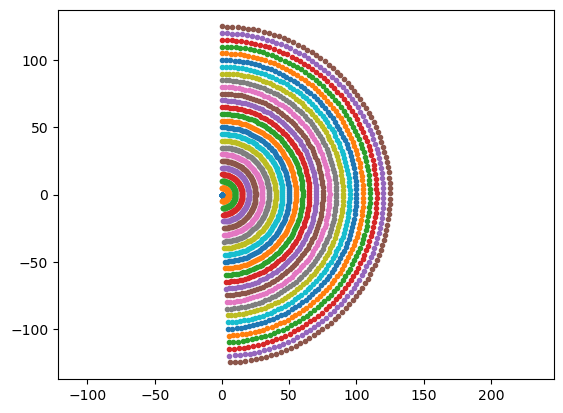

(6, 201, 256)


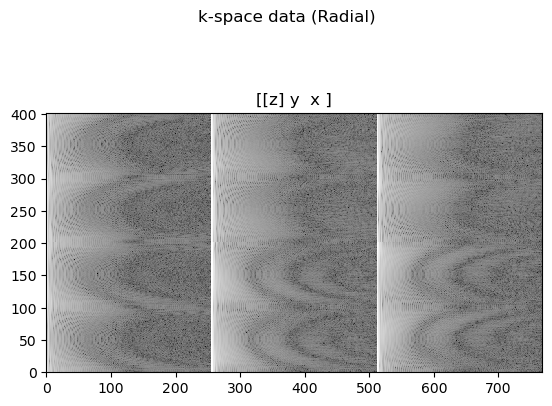

In [23]:
# Radial trajectory
nshots = int(img_size*np.pi) # number of shots (Nyquist criterion)
# nro = img_size//2  # Number of radial lines
nro = img_size  # Number of radial lines (x2 oversampling)

AF = 4
nshots = nshots//AF
print('nro = ', nro)
radial_traj = mri.radial([nshots, nro, 2], (img_size, img_size), golden=False)
# radial_traj = mri.radial([nshots, nro, 3], (img_size, img_size, img_size), golden=True)

plt.plot(radial_traj[:nshots//2, ::10, 0], radial_traj[:nshots//2, ::10, 1], '.')
plt.axis('equal')
plt.show()


# ksp_radial = sp.nufft(phantom * mps, coord = radial_traj)  # ラジアルトラジェクトリでサンプリング
ksp_radial = sp.nufft(img_sense, coord = radial_traj)  # ラジアルトラジェクトリでサンプリング
print(ksp_radial.shape)

pl.ImagePlot(np.abs(ksp_radial), title='k-space data (Radial)', z=0, mode='l')


# coil sensitivity estimation

JsenseRecon: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


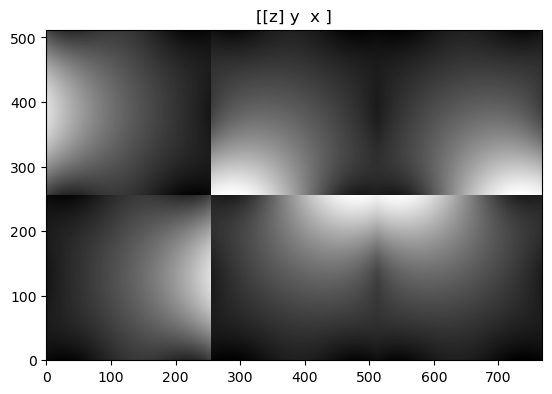

In [24]:
import sigpy.mri as mr
mps_est = mr.app.JsenseRecon(ksp_radial, coord=radial_traj, device=-1).run()  #cpu

pl.ImagePlot(mps, z=0)

# CG Sense with Tikhnov

SenseRecon: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s, obj=2.85E+01]


(254, 254)


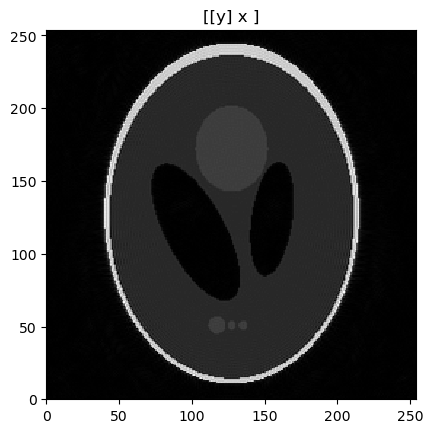

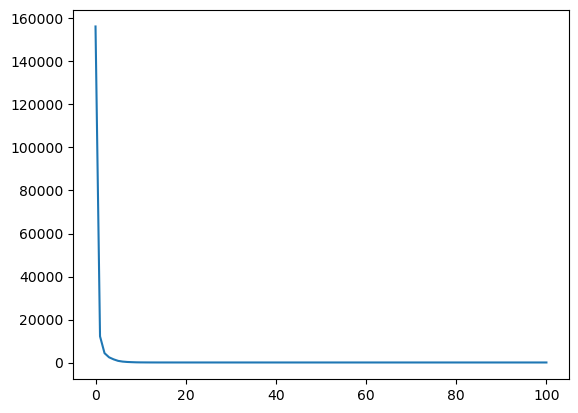

In [25]:
try:
    device = sp.Device(0)
except:
    device = sp.Device(-1)

# device = sp.Device(0)
xp = device.xp
device.use()

import sigpy.mri as mr
lamda = 0.01
max_cg_iter = 10
max_iter = 100


sense_app = mr.app.SenseRecon(
        ksp_radial, mps_est, lamda=lamda, coord=radial_traj, device=device, max_cg_iter=max_cg_iter,
        max_iter=max_iter, save_objective_values=True)

sense_img = sense_app.run()
print(sense_img.shape)

pl.ImagePlot(sense_img)

plt.plot(sense_app.objective_values)

# Density compensation

In [26]:
# precond_dcf = mr.pipe_menon_dcf(radial_traj, device=device)

dcf = np.sqrt(radial_traj[...,0]**2 + radial_traj[...,1]**2)


# adjoint nufft with density compensation

(254, 254)


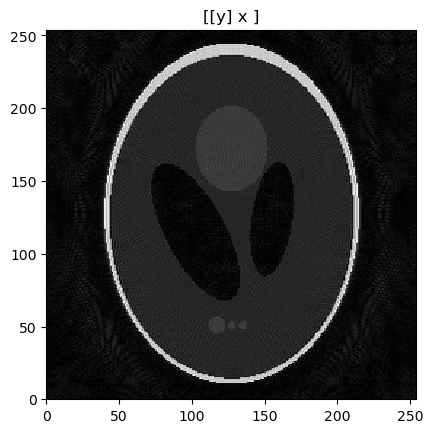

In [27]:
sense_op = mr.linop.Sense(mps_est, coord=radial_traj)
sense_adj = sense_op.H(ksp_radial*dcf)

print(sense_adj.shape)
pl.ImagePlot(sense_adj)